In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import ndimage
import math
import keras
import ast
import operator as op
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
!git clone https://github.com/vj2000/AutoGrading

fatal: destination path 'AutoGrading' already exists and is not an empty directory.


In [ ]:
dict_clean_img = {} 
dict_img = {}

keras.backend.set_image_data_format("channels_first")



In [ ]:
try:
    model = keras.models.load_model('/content/model.h5', compile=False)

except Exception as e:
    print('Model couldnot be loaded',e)

In [ ]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_LINEAR):
   
    dim = None
    (h, w) = image.shape[:2]

   
    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
       
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)

    return resized


operators = {ast.Add: op.add, ast.Sub: op.sub, ast.Mult: op.mul,
             ast.Div: op.truediv, ast.Pow: op.pow, ast.BitXor: op.xor,
             ast.USub: op.neg}

def eval_expr(expr):
    """
    >>> eval_expr('2^6')
    4
    >>> eval_expr('2**6')
    64
    >>> eval_expr('1 + 2*3**(4^5) / (6 + -7)')
    -5.0
    """
    return eval_(ast.parse(expr, mode='eval').body)

def eval_(node):
    if isinstance(node, ast.Num):
        return node.n
    elif isinstance(node, ast.BinOp): 
        return operators[type(node.op)](eval_(node.left), eval_(node.right))
    elif isinstance(node, ast.UnaryOp): 
        return operators[type(node.op)](eval_(node.operand))
    else:
        raise TypeError(node)



def sort_contours(cnts, method="left-to-right"):
   
    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

   
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

  
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    return (cnts, boundingBoxes)


def getBestShift(img):
   
    cy,cx = ndimage.measurements.center_of_mass(img)
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


def shift(img,sx,sy):
    
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

train_datagen = ImageDataGenerator(   
    data_format='channels_first',
    zca_whitening = True,
    rotation_range = 0.2)

def predict(img,x1,y1,x2,y2, proba = False, acc_thresh = 0.60):
  
    gray = img[y1:y2, x1:x2]

    temp = gray.copy()
    
    kernel_temp = np.ones((3,3), np.uint8) 
    temp_tmp = cv2.dilate(temp, kernel_temp, iterations=3)
    
  
    contours_tmp,hierarchy = cv2.findContours(temp_tmp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    if(len(contours_tmp) > 1):
        contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        mask = np.ones(gray.shape[:2], dtype="uint8") * 0
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        gray = cv2.bitwise_and(temp, temp, mask=mask)
        
    grayN = process_img (gray, resize_flag = 0)
    
    classes = model.predict(grayN, batch_size=2)
    ind = np.argmax(classes)
    c = ['0','1','2','3','4','5','6','7','8','9','+','-','*','(',')']

    
    if (proba == True):
        return classes[0][ind]
    
    return c[ind]

def process_img (gray, resize_flag = 1, preproc = 0):
   
    gray = gray.copy()
    
    if (preproc == 0):
        gray = cv2.GaussianBlur(gray,(7,7),0)
    else :
        kernel = np.ones((3,3), np.uint8)
        gray = cv2.dilate(gray, kernel, iterations=1)    
        gray = cv2.GaussianBlur(gray,(5,5),1)
        gray = cv2.dilate(gray, kernel, iterations=2)
        gray = cv2.erode(gray, kernel,iterations=2)    
    
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if(resize_flag) == 1:
        interpolation=cv2.INTER_AREA
    else:
        interpolation=cv2.INTER_CUBIC
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        gray = cv2.resize(gray, (cols,rows),interpolation=interpolation)
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        gray = cv2.resize(gray, (cols, rows),interpolation=interpolation)
   
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    grayS = shifted
    grayS = grayS.reshape(1,1,28,28)
    
    grayS = grayS/255
    
    return grayS

def extract_box(img, show=True):
   
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    thresh, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    kernel_length = np.array(binary_image).shape[1]//80

    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    img_temp1 = cv2.erode(binary_image, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

    img_temp2 = cv2.erode(binary_image, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)
    
    alpha = 0.5
    beta = 1.0 - alpha
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    if(cv2.__version__ == '3.3.1'): 
        xyz,contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    
    area = []
    for contour in contours:
        area.append(cv2.contourArea(contour))
    
    s = np.argsort(area) 
    
    workspace_contours = []    
    for i,contour in enumerate(contours):
        if cv2.contourArea(contour) >= area[s[-1]]*0.40  and cv2.contourArea(contour) < area[s[-1]]*0.50:
            workspace_contours.append(contour)
    
    rectangle_locs =[]   
    
    for cnt in workspace_contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rectangle_locs.append([x,y,w,h])        
    
    if (show):
        fig = plt.figure(figsize=(7,9))
        fig.suptitle('Extracted Workspaces')
        i=1
        l = len(rectangle_locs)
        for rect in rectangle_locs:
            ax = fig.add_subplot(l,1,i)
            ax.imshow(img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])
            i = i+1
        plt.show()
        
    return rectangle_locs



def find_good_contours_thres(conts, alpha = 0.002):

    areas = []
    
    for c in conts:
        areas.append([cv2.contourArea(c)**2])
    thres = alpha * max(areas)[0]
    
    return thres

def extract_line(image, beta=0.7, alpha=0.002, show = True):

    img = image.copy()
    H,W = img.shape[:2]
    h5 = int(.02 * H)
    w5 = int(.02 * W)
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(threshed,kernel,iterations = 1)
    
    temp = dilation.copy()
    
    if(cv2.__version__ == '3.3.1'): 
        xyz,contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    cont_thresh = find_good_contours_thres(contours, alpha=alpha)

    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255

    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh):
            cv2.drawContours(mask, [c], -1, 0, -1)
    
    cleaned_img = cv2.bitwise_and(temp, temp, mask=mask)
    

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 10)
    
    cleaned_orig = cv2.erode(cleaned_img, kernel, iterations=1) 
    
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    
    th = 1
    H,W = img.shape[:2]
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_1 = np.array([True if j > beta*(np.mean(diff_1)-np.std(diff_1)) else False for j in diff_1 ])
    
    uppers = uppers[diff_index_1]
    lowers = lowers[diff_index_1]
    
   
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:], diff_1[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1], diff_1[:-1])]
    
    diff_2 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_2 = np.array([True]*len(uppers))
    
  
    for i,diff in enumerate(diff_2):
        if(i>0):
            if( (diff_2[i-1] < (diff/2)) and (( lowers[i-1]-uppers[i]) > ((lowers[i-1]-uppers[i-1])/5)) ):
                uppers[i] = uppers[i-1]
                diff_2[i] = diff_2[i]+diff_2[i-1]
                diff_index_2[i-1] = False
                print('Merging')

    diff_index = diff_index_2
    
    cleaned_orig_rec = cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2BGR)
    
    col_ct = 0
    
    for left,right in zip(uppers[diff_index], lowers[diff_index]):
        col1 = (153,255,255)
        col2 = (255,255,153)
        if(col_ct % 2 == 0):
            col= col1
        else: 
            col=col2
        cv2.rectangle(cleaned_orig_rec ,(0+10,left),(W-15,right),col,4)
        col_ct += 1
        
    if(show == True):
        fig0 = plt.figure(figsize=(15,5))
        ax1 = fig0.add_subplot(1,3,1)
        ax1.set_title('Original Image')
        ax1.imshow(img)
        ax1.axis('off')
        
        ax2 = fig0.add_subplot(1,3,2)
        ax2.set_title('Cleaned Image')
        ax2.imshow(cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2RGB))
        ax2.axis('off')
        
        ax3 = fig0.add_subplot(1,3,3)
        ax3.set_title('Noises')
        ax3.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        ax3.axis('off')
        
        fig0.suptitle('Denoising')
        plt.show()
    
        fig1 = plt.figure(figsize=(15,5))
        fig1.suptitle('Line Detection')
        ax1 = fig1.add_subplot(1,2,1)
        ax1.axis("off")
        ax1.imshow(cv2.cvtColor(cleaned_orig,cv2.COLOR_BGR2RGB))
        
        ax2 = fig1.add_subplot(1,2,2)    
        ax2.axis("off")
        ax2.imshow(cv2.cvtColor(cleaned_orig_rec, cv2.COLOR_BGR2RGB))
        
        plt.show()
    
    return cleaned_orig, uppers[diff_index], lowers[diff_index]


def evaluate(df,A,B,X,Y):
   
    actual = A*X*X+(B*Y)
    
    try:
        pred = df["exp"].apply(lambda d: "**" if d==1 else "")
        pred = "".join(list(pred+df["pred"]))
        
     
        matchesN = re.findall('^\-\-', pred)
        if(len(matchesN) > 0):
            for s in matchesN:
                pred = pred.replace(s,'')       
                
            
        matches5 = re.findall(r'5\*\*-\D*', pred)
        if(len(matches5) > 0):
            for s in matches5:
                sn = s.split('5**-')
                snew = sn[0]+'5'+sn[1]
                pred = pred.replace(s,snew)  

     
        matchesB_left = re.findall(r'\d\(\d', pred)
        matchesB_right = re.findall(r'\d\)\d', pred)
        
        if(len(matchesB_left) > 0 or len(matchesB_right) > 0):
            for s in matchesB_left:
                sn = s.split('(')
                snew = sn[0]+'*('+sn[1]
                pred = pred.replace(s,snew)    
                
            for s in matchesB_right:
                sn = s.split(')')
                snew = sn[0]+')*'+sn[1]
                pred = pred.replace(s,snew) 
        
        ans = eval_expr(pred)
        print(pred )

        if(df['pred_proba'].mean() < 0.75):
            return 5
        
    except Exception as e:
        print(pred,'-',e)
        return 5
    
    return actual==ans
	
def draw_contour(image, c, i):

	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])
 
	cv2.putText(image, "#{}".format(i + 1), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX,
		1.0, (255, 255, 255), 2)
 
	return image

def text_segment(Y1,Y2,X1,X2,box_num,line_name, dict_clean = dict_clean_img,\
                 acc_thresh = 0.60, show = True):
  
    img = dict_clean[box_num][Y1:Y2,X1:X2].copy()
    L_H = Y2-Y1
  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(img,kernel,iterations = 2)
    erosion = cv2.erode(dilation,kernel,iterations = 1)
    
    if(cv2.__version__ == '3.3.1'):
        xyz,contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    ct_th = find_good_contours_thres(contours, alpha=0.005)
    cnts = []
    for c in contours:       
        if( cv2.contourArea(c)**2 > ct_th):
            cnts.append(c)
    contours_sorted,bounding_boxes = sort_contours(cnts,method="left-to-right")
    char_locs = []
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    i = 0
    char_type =[]
    while i in range(0, len(contours_sorted)):
            x,y,w,h = bounding_boxes[i]
            exp = 0
            if i+1 != len(contours_sorted):
                x1,y1,w1,h1 = bounding_boxes[i+1]
                if abs(x-x1) < 10 and  (h1+h) < 70:
                    #print(h+h1)
                    minX = min(x,x1)
                    minY = min(y,y1)
                    maxX = max(x+w, x1+w1)
                    maxY = max(y+h, y1+h1)
                    x,y,x11,y11 = minX, minY, maxX, maxY
                    
                    x,y,w,h = x,y,x11-x,y11-y
                    i = i+2
                    continue
            
            if(h<0.10*L_H and w<0.10*L_H):
                i=i+1
                continue

            char_locs.append([x-2,y+Y1-2,x+w+1,y+h+Y1+1,w*h]) 
            
            cv2.rectangle(img,(x,y),(x+w,y+h),(153,180,255),2)

            if i!=0:
                if y+h < (L_H*(1/2)) and y < bounding_boxes[i-1][1] and h < bounding_boxes[i-1][3]:
                    exp = 1
                    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            i = i+1
            char_type.append(exp)
             
    

    df_char = pd.DataFrame(char_locs)
    df_char.columns=['X1','Y1','X2','Y2','area']
    df_char['exp'] = char_type
    df_char['pred'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], acc_thresh=acc_thresh), axis=1 )
    df_char['pred_proba'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], proba=True, acc_thresh=acc_thresh), axis=1 )
    df_char.apply(lambda c: cv2.putText(img, c['pred'], (c['X1']-10,35), cv2.FONT_HERSHEY_SIMPLEX,  
                   1.5,(147,96,247), 3, cv2.LINE_AA), axis=1) 
    df_char['line_name'] = line_name
    df_char['box_num'] = box_num

    if(show == True):        
        plt.figure(figsize=(15,8))   

        plt.axis("on")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    	  
    return [box_num,line_name,df_char]


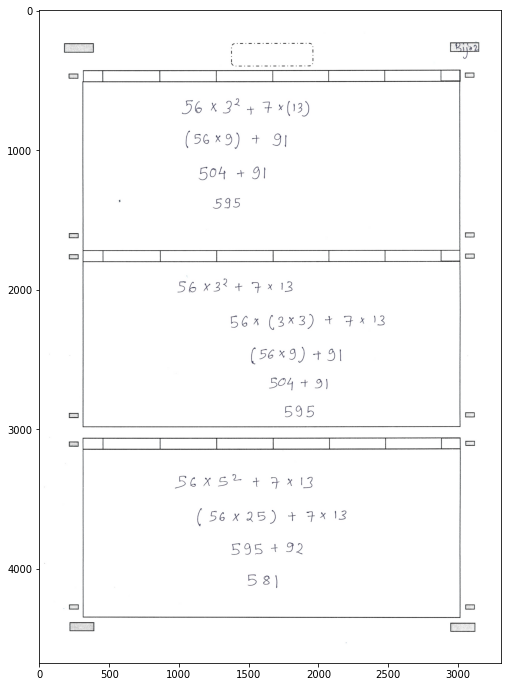

In [ ]:
image_path = "/content/AutoGrading/data/image_7.jpg"
A = 2
B = 2
X = 98
Y = 3

img = cv2.imread(image_path)
plt.figure(figsize=(12,12))
plt.imshow(img)


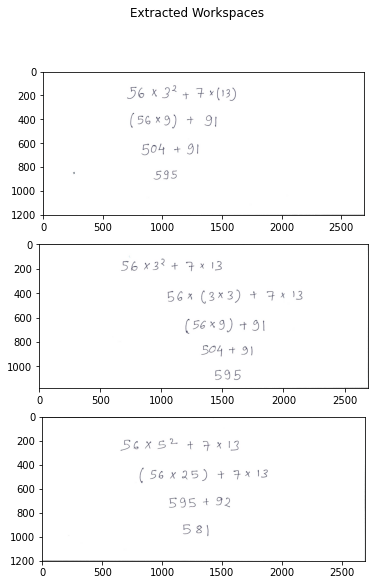

In [ ]:
workspaces = extract_box(img)

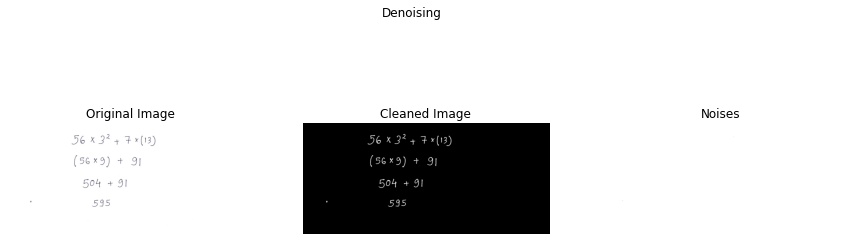

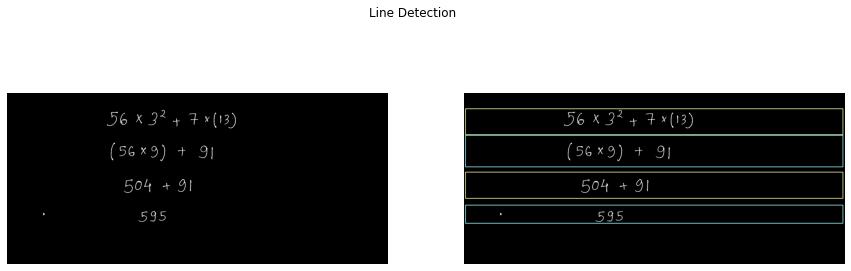

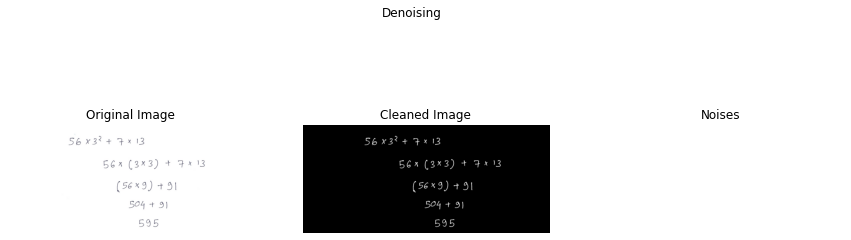

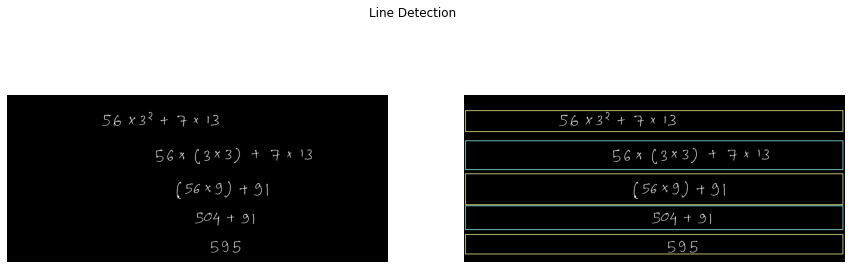

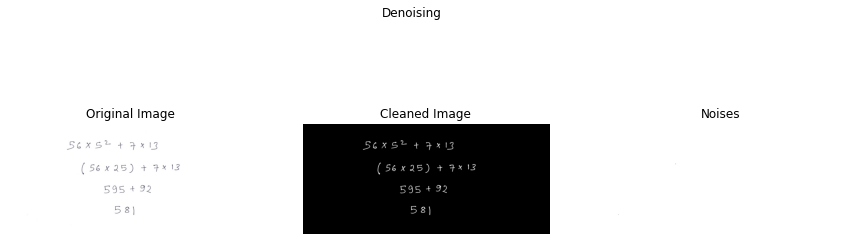

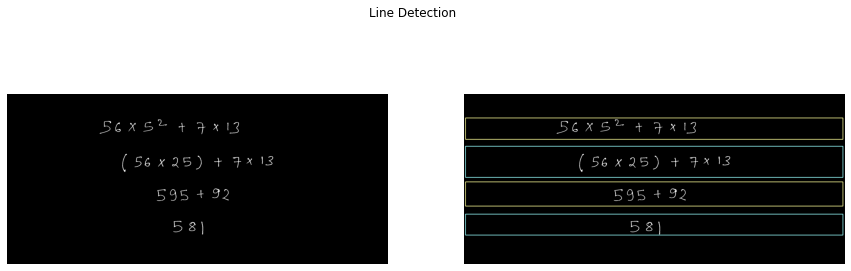

In [ ]:
df_lines = pd.DataFrame()

for r,rect in enumerate(workspaces):
    box = img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
    H,W = box.shape[:2]
    cleaned_orig,y1s,y2s = extract_line(box, show=True)
    x1s = [0]*len(y1s)
    x2s = [W]*len(y1s)
    

    
    df = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
    df.columns = ['y1','y2','x1','x2']
    df['box_num'] = r

    df_lines= pd.concat([df_lines, df])

    dict_clean_img.update({r:cleaned_orig})
    dict_img.update({r:box})
    

df_lines['line_name'] = ['%d%d' %(df_lines.box_num.iloc[i],df_lines.index[i]) \
        for i in range(len(df_lines))]
    
    

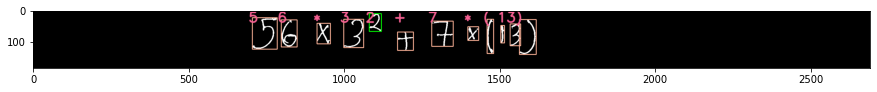

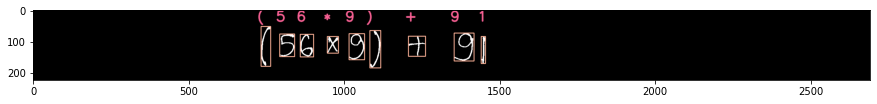

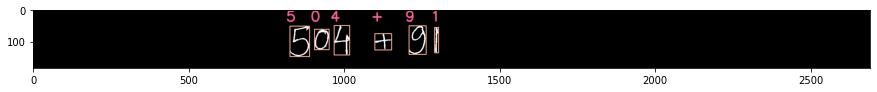

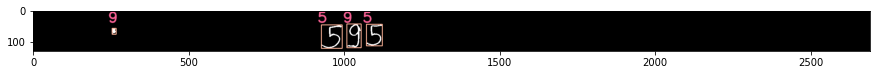

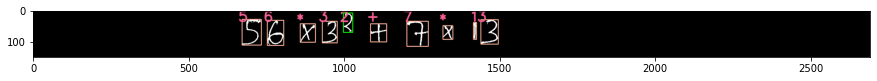

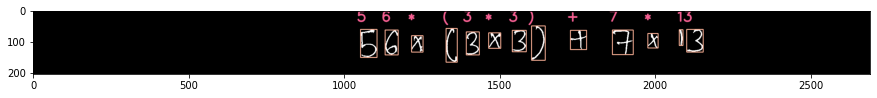

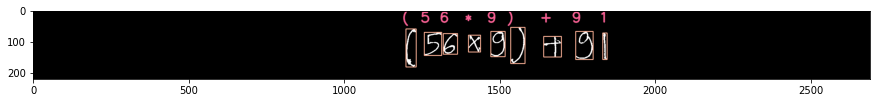

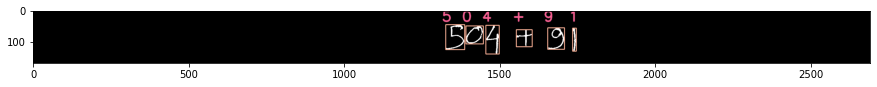

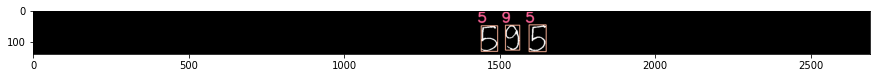

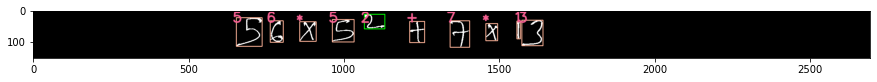

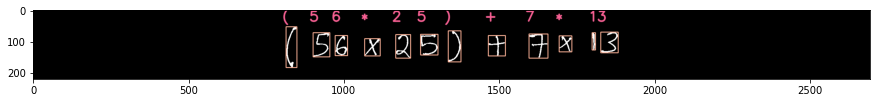

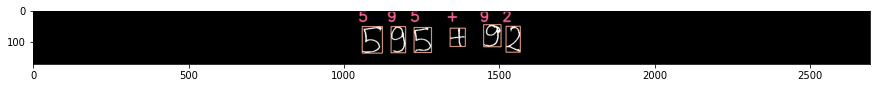

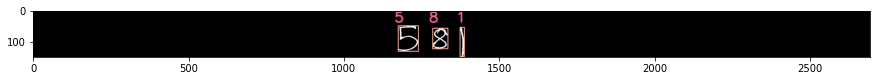

In [ ]:
list_chars = list(df_lines.apply(lambda row: text_segment(row['y1'],row['y2'],\
                 row['x1'],row['x2'], row['box_num'],row['line_name'], \
                 show=True), axis=1))
    


In [ ]:
df_chars = pd.DataFrame(list_chars)
df_chars.columns = ['box_num', 'line_name', 'char_df']
    
box_nums = df_chars.box_num.unique()
char_area_list = []
df_chars['char_df'].apply(lambda d: char_area_list.append(list(d['area'])) )

gamma = 0
max_ar = max([max(i) for i in char_area_list])
ar_thresh = max_ar*gamma

df_chars['char_df'] = df_chars['char_df'].apply(lambda d: d[d.area > ar_thresh] )

for bn in box_nums:
    print('BOX %d' %(bn+1))
    box_img = dict_clean_img[bn] 
    box_img_1 = dict_img[bn]
    box_img = cv2.cvtColor(box_img, cv2.COLOR_GRAY2BGR)
    
    df = df_chars[df_chars.box_num == bn].copy()
    df_l = df_lines[df_lines["box_num"]==bn].copy() 
    
    df['char_df'].apply(lambda d: d.apply(lambda c: cv2.rectangle(box_img, \
      (c['X1'],c['Y1']),(c['X2'], c['Y2']),(255*(c['exp']==1),180,0),2+(2*c['exp'])), axis=1 ) )
    
    df['line_status'] = df['char_df'].apply(lambda d: evaluate(d[["pred","exp","pred_proba"]],A,B,X,Y))
    
    scale_percent = 200 
    width = int(box_img.shape[1] * scale_percent / 100)
    height = int(box_img.shape[0] * scale_percent / 100)
    dim = (width, height)    
    box_img = cv2.resize(box_img, dim, interpolation = cv2.INTER_AREA)

    df_l['line_status'] = list(df['line_status']) 
    df_l.apply(lambda c: cv2.rectangle(box_img_1, (c['x1'],c['y1']),(c['x2'],\
      c['y2']),(255*(c['line_status']==5),255*(c['line_status']==True),\
                                255*(c['line_status']==False)),2), axis=1)
    



BOX 1
56*3**2+7*(13)
(56*9)+91
504+91
9595
BOX 2
56*3**2+7*13
56*(3*3)+7*13
(56*9)+91
504+91
595
BOX 3
56*5**2+7*13
(56*25)+7*13
595+92
581
